# High Dynamic Range (HDR) Imaging

**Satya Mallick, LearnOpenCV.com**

!["HDR Image Example"](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_10_high-dynamic-range-hdr.jpg)

In [1]:
# Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

##  <font style="color:black">Download Assets</font>

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/qa1hsyxt66pvj02/opencv_bootcamp_assets_NB10.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB10.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

# Basic Idea

1. The **dynamic range** of images is limited to 8-bits (0 - 255) per channel
2. Very bright pixels saturate to 255
3. Very dark pixels clip to 0

# Step 1: Capture Multiple Exposures

!["HDR Image Sequence"](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_10_hdr-image-sequence.jpg)

In [4]:
def readImagesAndTimes():
    # List of file names
    filenames = ["img_0.033.jpg", "img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]

    # List of exposure times
    times = np.array([1 / 30.0, 0.25, 2.5, 15.0], dtype=np.float32)

    # Read images
    images = []
    for filename in filenames:
        im = cv2.imread(filename)
        images.append(im)

    return images, times

# Step 2: Align Images

![Aligned vs. Unaligned](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_10_aligned-unaligned-hdr-comparison.jpg)

In [5]:
# Read images and exposure times
images, times = readImagesAndTimes()

# Align Images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)

# Step 3: Estimate Camera Response Function

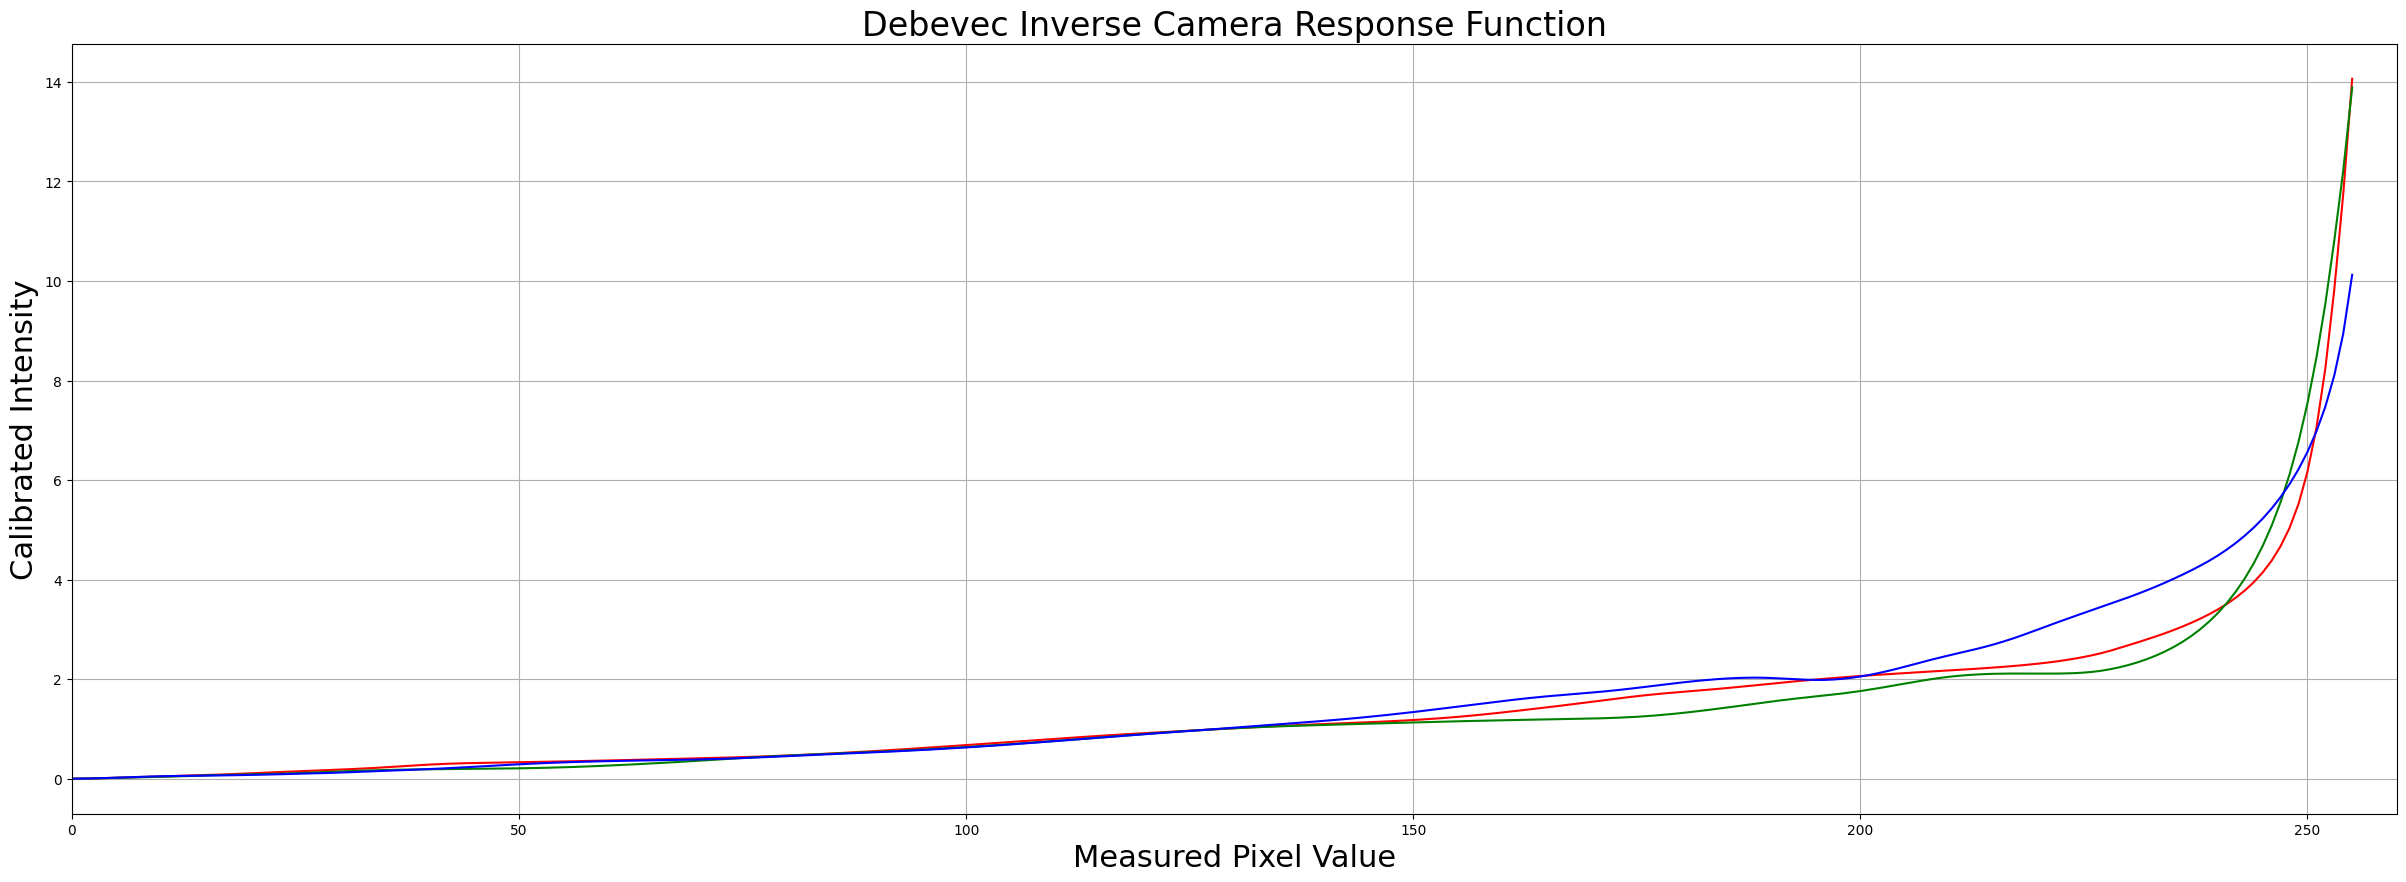

In [6]:
# Find Camera Response Function (CRF)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

# Plot CRF
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30, 10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0, 260])
plt.grid()
plt.plot(x, y[:, 0], "r", x, y[:, 1], "g", x, y[:, 2], "b")

# Step 4: Merge Exposure into an HDR Image

In [7]:
# Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

# Step 5: Tonemapping

Many Tonemapping algorithms are available in OpenCV. We chose Durand as it has more controls.

saved ldr-Drago.jpg


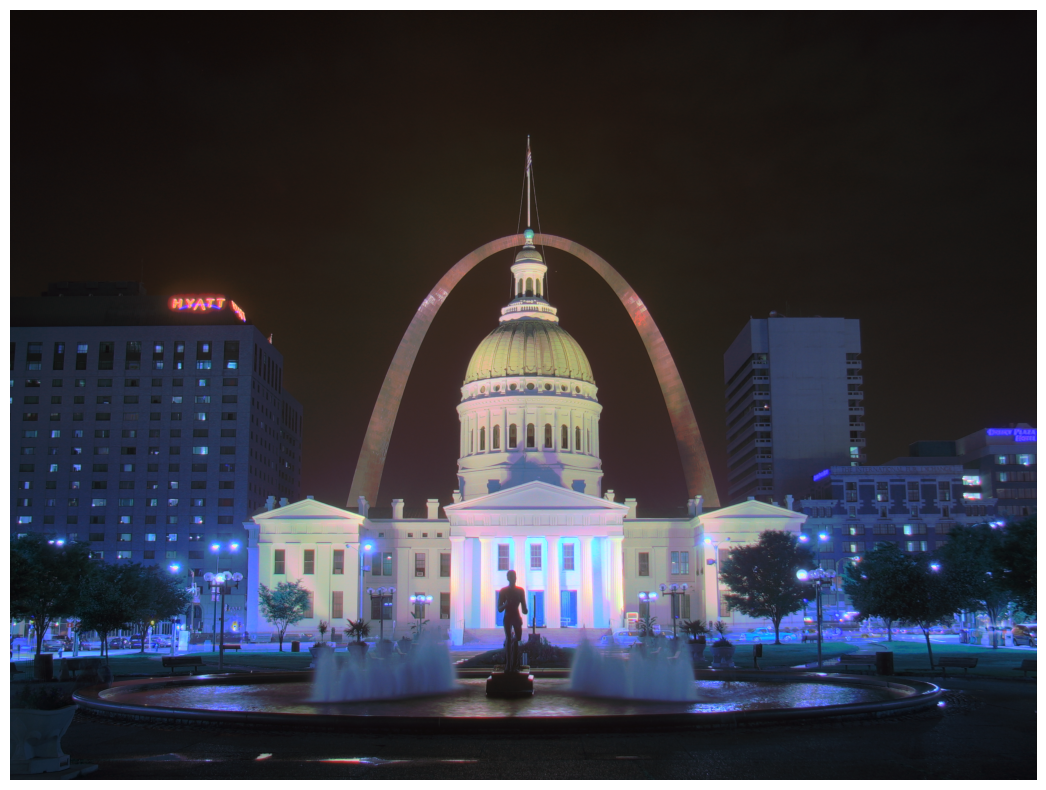

In [8]:
# Tonemap using Drago's method to obtain 24-bit color image
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago

plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrDrago, 0, 1));plt.axis("off")

cv2.imwrite("ldr-Drago.jpg", 255*ldrDrago[:, :, ::-1])
print("saved ldr-Drago.jpg")

Tonemaping using Reinhard's method ... 
saved ldr-Reinhard.jpg


d:\Users\CuongTa\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


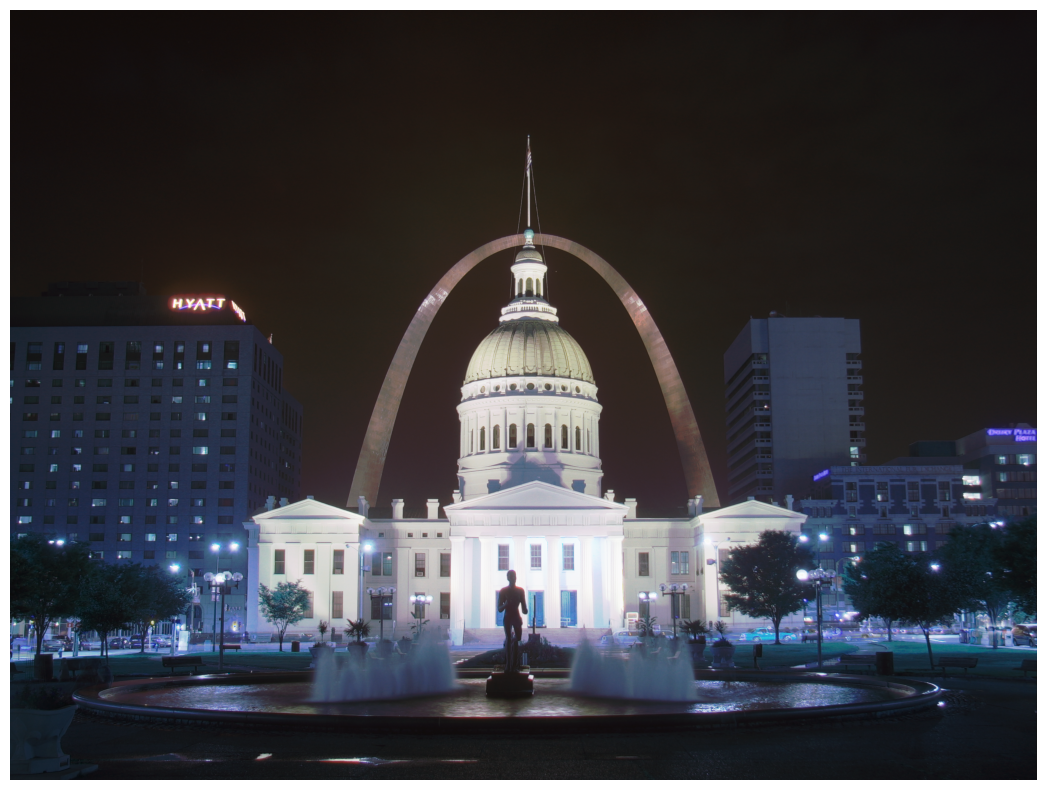

In [9]:
# Tonemap using Reinhard's method to obtain 24-bit color image
print("Tonemaping using Reinhard's method ... ")
tonemapReinhard = cv2.createTonemapReinhard(1.5, 0, 0, 0)
ldrReinhard = tonemapReinhard.process(hdrDebevec)

plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrReinhard, 0, 1));plt.axis("off")

cv2.imwrite("ldr-Reinhard.jpg", ldrReinhard * 255)
print("saved ldr-Reinhard.jpg")

Tonemaping using Mantiuk's method ... 
saved ldr-Mantiuk.jpg


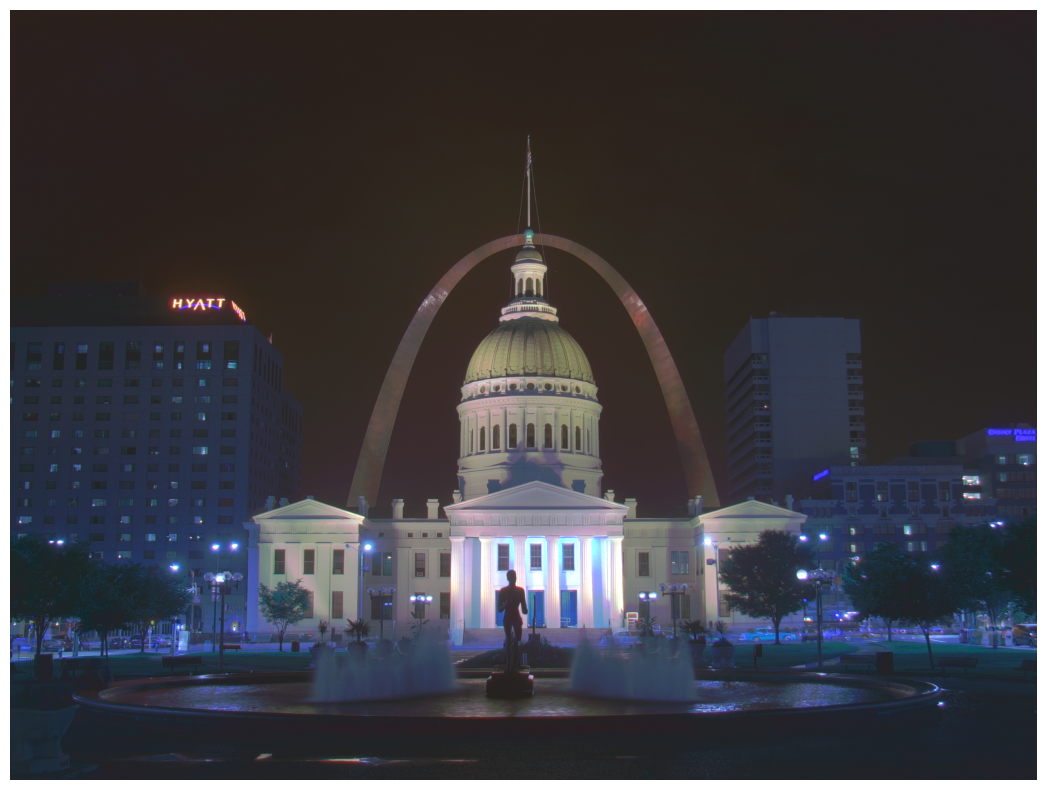

In [10]:
# Tonemap using Mantiuk's method to obtain 24-bit color image
print("Tonemaping using Mantiuk's method ... ")
tonemapMantiuk = cv2.createTonemapMantiuk(2.2, 0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(hdrDebevec)
ldrMantiuk = 3 * ldrMantiuk

plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrMantiuk, 0, 1));plt.axis("off")

cv2.imwrite("ldr-Mantiuk.jpg", ldrMantiuk * 255)
print("saved ldr-Mantiuk.jpg")